# Week 6 - Classification models  

## Part 4: Travel mode choice - Hierarchical models



This part is where we start to make things more interesting :-)

We will revisit the original real world problem of travel model choice (with 4 classes), but this time we shall consider a hierarchical model. 

More on that later, for now the same stuff from part 2: imports, loading data, preprocessing, train/test split, etc.

Import required libraries:

In [36]:
# Install Pyro, if necessary
!pip install pyro-ppl

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

c:\Users\jakob\anaconda3\envs\my_environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data:

In [2]:
# load csv
df = pd.read_csv("http://mlsm.man.dtu.dk/mbml/modechoice_data.csv", index_col=0)
df.head()

,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,70.0,30.0,4.0,10.0,61.0,80.0,73.0,44.0,24.0,350.0,77.0,53.0,19.0,395.0,79.0,4.0,314.0,52.0,1.0
1,8.0,15.0,4.0,64.0,48.0,154.0,71.0,55.0,25.0,360.0,80.0,53.0,14.0,462.0,84.0,4.0,351.0,57.0,2.0
2,62.0,35.0,2.0,64.0,58.0,74.0,69.0,30.0,21.0,295.0,66.0,53.0,24.0,389.0,83.0,7.0,315.0,55.0,2.0
3,61.0,40.0,3.0,45.0,75.0,75.0,96.0,44.0,33.0,418.0,96.0,53.0,28.0,463.0,98.0,5.0,291.0,49.0,1.0
4,27.0,70.0,1.0,20.0,106.0,190.0,127.0,34.0,72.0,659.0,143.0,35.0,33.0,653.0,104.0,44.0,592.0,108.0,1.0


Preprocess data:

In [10]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,2:-1]
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")
print(ind.shape)

(394, 16)
(394,)
(394,)


In [4]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [5]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 260
num test: 134


Our baseline logistic regression model from sklearn:

In [6]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 4 1 4 4 4 3 1 2 2 1 4 2 1 2 4 4 4 4 2 4 1 4 1 2 4 4 4 4 3 4 4
 3 2 4 4 2 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 1 2 4 4 4
 4 4 1 2 2 2 4 4 1 4 3 4 4 4 1 4 3 1 4 2 1 4 1 4 4 4 1 1 2 1 3 4 4 4 4 4 4
 4 4 1 3 1 1 4 3 2 4 1 4 2 1 1 2 2 2 4 4 4 4 4]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6791044776119403


## Hierarchical logistic regression in Pyro

We will now implement a hierarchical logistic regression. The motivation is actually quite simple. Our dataset consists of multiple observations from various individuals. However, when we build our original logistic regression in Pyro, our specification assumes that all individuals share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all individuals are equally biased towards a given mode (e.g. car). This is obviously a very strong assumption, right? We should allow different individuals to have different biases (alpha). (We could also consider different coefficients per individual, but for the sake of simplicy, we will just focus on the bias parameters)

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global intercept mean $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global intercept variance $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. Draw coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
    6. For each individual $i \in \{1,\dots,I\}$
        4. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the individual identifier for person $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

Notice that now, instead of a single intercept per class $\alpha_c$ for all individual, we now have a vector of intercepts $\boldsymbol\alpha_c$ for each class $c$: one intercept parameter per individual! However, all these intercept share a global (population-level) prior.

Let's try to implement this in Pyro. Can you do it? :-) 

In [64]:
import torch.nn as nn

# def hierarchical_model(X, ind, n_cat, n_ind, obs=None):
#     amount_feautures = X.shape[1]
#     lambda_ = 10
#     global_mean = pyro.sample("global_mean", dist.Normal(torch.zeros(n_cat), lambda_ * torch.ones(n_cat)).to_event())
#     global_std = pyro.sample("global_std", dist.HalfCauchy(scale = lambda_ * torch.ones(n_cat)).to_event())
#     beta = pyro.sample("beta", dist.Normal(torch.zeros((amount_feautures, n_cat)), lambda_ * torch.ones((amount_feautures, n_cat))).to_event())
#     alpha = pyro.sample("alpha", dist.Normal(torch.ones(n_ind, global_mean.shape[0]) * global_mean, torch.ones(n_ind, global_mean.shape[0]) * global_std).to_event())
#     with pyro.plate("data"):
#         y = pyro.sample("y", pyro.distributions.Categorical(probs = nn.Softmax(dim=1)(alpha[ind] + X @ beta)), obs=obs)
#     return y


def hierarchical_model(X, ind, n_cat, n_ind, obs=None):
    amount_feautures = X.shape[1]
    lambda_ = 10
    global_mean = pyro.sample("global_mean", dist.Normal(torch.zeros(n_cat), lambda_ * torch.ones(n_cat)).to_event())
    global_std = pyro.sample("global_std", dist.HalfCauchy(scale = lambda_ * torch.ones(n_cat)).to_event())
    beta = pyro.sample("beta", dist.Normal(torch.zeros((amount_feautures, n_cat)), lambda_ * torch.ones((amount_feautures, n_cat))).to_event())
    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(global_mean, global_std).to_event(1))
    with pyro.plate("data"):
        y = pyro.sample("y", pyro.distributions.Categorical(logits = alpha[ind] + X.matmul(beta)), obs=obs)
    return y

Prepare the data for Pyro:

In [17]:
# Prepare data for Pyro model
n_cat = int(y_train.max())
n_ind = ind.max()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

C:\Users\jakob\AppData\Local\Temp\ipykernel_10144\2186691789.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
C:\Users\jakob\AppData\Local\Temp\ipykernel_10144\2186691789.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\jakob\AppData\Local\Temp\ipykernel_10144\2186691789.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers


Run inference using SVI:

In [65]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, ind_train-1, n_cat, n_ind, y_train-1)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4135.2
[500] ELBO: 1260.5
[1000] ELBO: 737.1
[1500] ELBO: 609.3
[2000] ELBO: 553.9
[2500] ELBO: 518.4
[3000] ELBO: 494.6
[3500] ELBO: 471.0
[4000] ELBO: 466.6
[4500] ELBO: 476.3
[5000] ELBO: 455.1
[5500] ELBO: 450.8
[6000] ELBO: 460.5
[6500] ELBO: 446.2
[7000] ELBO: 450.8
[7500] ELBO: 450.9
[8000] ELBO: 444.2
[8500] ELBO: 447.7
[9000] ELBO: 458.4
[9500] ELBO: 465.0
[10000] ELBO: 456.9
[10500] ELBO: 445.0
[11000] ELBO: 443.4
[11500] ELBO: 444.5
CPU times: total: 6min 7s
Wall time: 6min 29s


Once converged, let's extract the posterior samples for the latent variables in the model using Pyro's ```Predictive``` class:

In [68]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "global_mean", "global_std"))
samples = predictive(X_train, ind_train-1, n_cat, n_ind, y_train-1)

Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

In [70]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["global_mean"].detach().numpy()
alpha_sigma_samples = samples["global_std"].detach().numpy()

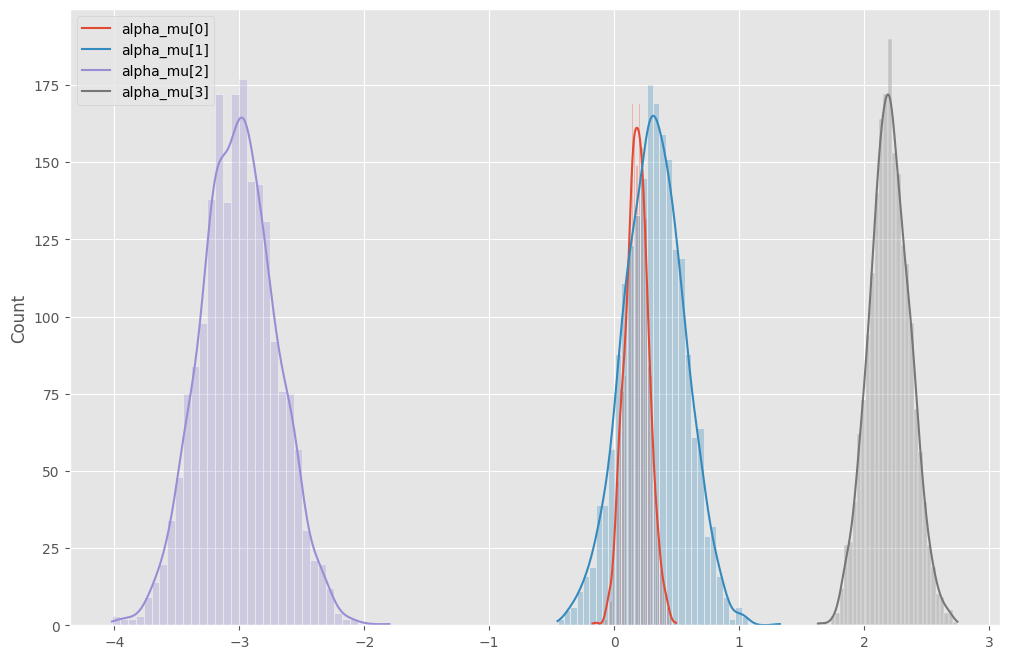

In [71]:
for c in range(n_cat):
    sns.histplot(alpha_mu_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_mu[%d]" % c for c in range(n_cat)])
plt.show()

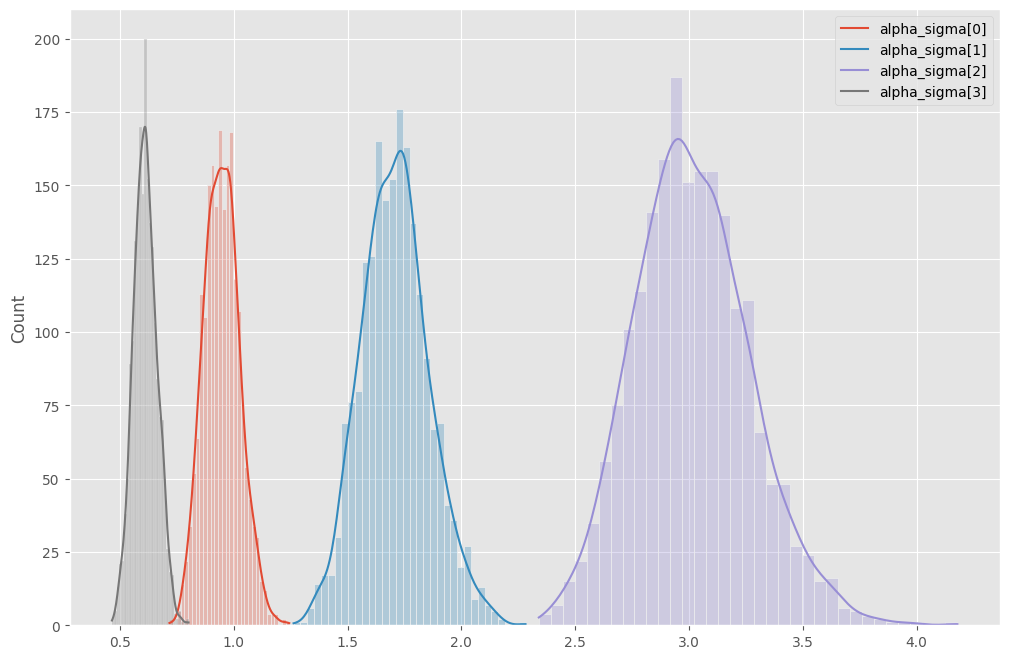

In [17]:
for c in range(n_cat):
    sns.histplot(alpha_sigma_samples[:,0,c], kde=True, alpha=0.3)
plt.legend(["alpha_sigma[%d]" % c for c in range(n_cat)])
plt.show()

We can now use the inferred posteriors to make predictions:

In [13]:
# extract expected values of the parameters
alpha_hat = alpha_samples.mean(axis=0)
beta_hat = beta_samples.squeeze().mean(axis=0)

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per-individual, and adapt the code for making predictions accordingly. Make sure that you understand the code below. As always, if something is not 100% clear, ask! :-)

In [14]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1,:] + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 2 4 4 4 3 1 2 2 1 4 2 1 2 4 4 4 4 2 3 2 4 1 2 4 4 4 4 3 1 1
 3 4 1 4 4 2 2 2 1 1 3 4 3 1 4 4 1 1 4 2 4 4 1 3 2 4 2 4 3 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 4 4 4 1 3 3 1 4 2 1 4 1 4 4 4 1 1 4 4 3 2 4 4 2 1 4
 4 4 1 3 1 1 4 3 2 4 1 4 2 1 1 4 2 2 1 3 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6865671641791045


Now, that is an improvement, right? We improved the accuracy of our model from about 67.9% to 68.6% :-) 

(Hopefully you were able to obtain a similar or even better result... If not, go back to optimization procedure of SVI above and try tweaking the learning rate ```lr```, the number of gradient steps ```n_steps``` and the ```num_particles```. Try to understand how those affect the convergence, stability and results of SVI.)

Did you see how your prior knowledge about the problem can make a difference when building a model for it? This is how things are done in the model-based machine learning approach!

Given the posterior distributions inferred by Pyro, we can even analyse the biases of different individuals identified by our model:

In [15]:
np.set_printoptions(precision=3)
for i in range(n_ind):
    print(i, alpha_hat[i,:])

0 [-0.058  0.157 -3.522  1.921]
1 [-0.086  0.298 -3.764  1.883]
2 [-0.144  0.292 -3.708  1.873]
3 [ 0.413  0.947 -6.405  1.716]
4 [-0.115  0.291 -3.743  1.891]
5 [-0.212  0.63  -2.172  1.859]
6 [-0.134  0.263 -3.523  1.91 ]
7 [ 0.661  2.23  -3.346  1.369]
8 [-0.052  0.318 -3.517  1.948]
9 [-0.33   0.655 -4.095  1.938]
10 [-0.072  0.413 -3.458  1.871]
11 [-0.704  1.512 -4.237  2.031]
12 [-0.132  0.329 -3.508  1.979]
13 [-0.087  0.294 -3.454  1.868]
14 [-0.509  1.648 -4.171  1.889]
15 [-0.097  0.313 -3.566  1.876]
16 [-0.16   0.349 -3.655  1.909]
17 [ 0.746  0.877 -4.202  1.517]
18 [-0.147  0.4   -3.468  1.813]
19 [-0.035  0.683 -2.032  1.72 ]
20 [-0.142  0.342 -3.569  1.938]
21 [-0.144  0.414 -3.671  1.889]
22 [-0.064  0.373 -3.615  1.943]
23 [-0.146  0.307 -3.621  1.893]
24 [-0.066  0.284 -3.53   1.951]
25 [-0.054 -0.119 -1.698  1.816]
26 [-0.079  0.343 -3.82   1.863]
27 [-0.087  0.283 -3.744  1.925]
28 [ 0.158  0.224 -4.389  1.808]
29 [-0.456  0.094 -4.628  2.045]
30 [-0.082  0.313 -3

Perhaps a histogram allows for a better global analysis:

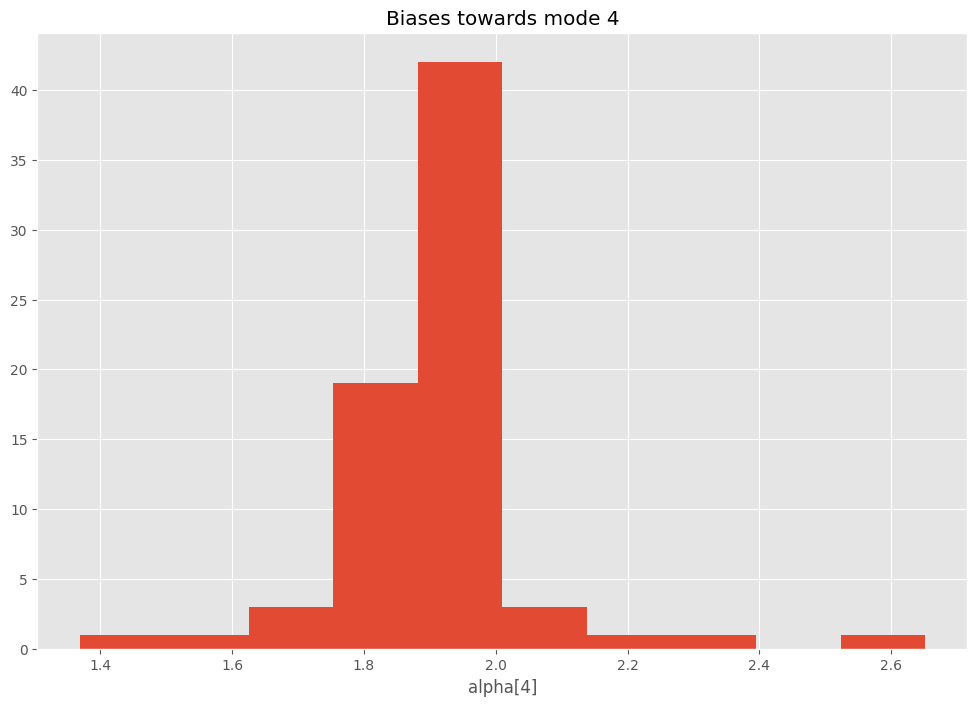

In [16]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha_hat[:,3])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observe that, for most individuals the biases is around 2.

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?